**Análise de Preços de fechamento do Ibovespa**
**Pós-Tech Data Analytics**<br/>
**Turma:** 5DTAT<br/>
**Grupo:** 65<br/>

<br/>

**Membros do grupo**

| Integrantes                        | RM              |
| ---------------------------------- | --------------- |
| Felipe David Abdala                | RM355751        |
| Lucas Cardoso de Oliveir           | RM354959        |
| Natanael Amaro Honório dos Santos  | RM355375        |

<br/>

**Objetivo:**<br/>

> Neste notebook é exposta a série temporal de preços do IBOVESPA, durante 34 anos, compreendendo o período de 01/01/1990 à 15/07/2024. Posteriormente tratatada, para contemplar apenas de 01/01/2000 à 15/07/2024. /<br/>
Com o intuito de testar modelos estatísticos que prevejam com acuracidade qual o preço de fechamento do índice da bolsa de valores brasileira (B3), o IBOVESPA.

<br/>

**Diretório:**<br/>
> O diretório do Git-hub com os scripts é o seguinte:
https://github.com/Felipe-Abdala/Tech_Challenge_Fase2


<br/>

**Metodologia:**<br/>

> Foram utilizados modelos de predição a fim de detectar qual melhor se adequaria para fins de previsão do valor de fechamento da bolsa brasileira (B3), com isso, foram utiilzadas as técnicas de modelagem de:
* Modelo Status Forecast (baseline, sazonalidade e base móvel);
* ARIMA;
* XGBoost;
* Prophet;
* SARIMAX.



#'1. Importação bibliotecas

In [1]:
!pip install statsforecast

In [2]:
import pandas as pd
#import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import mean_absolute_error,  mean_squared_error, mean_absolute_percentage_error
import numpy as np
import xgboost as xgb
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

# '2. Importação da base de dados

In [3]:
base_1990_2009 = pd.read_csv('https://github.com/Felipe-Abdala/Tech_Challenge_Fase2/blob/main/DadosHistoricos_Ibovespa_1990_2009.csv?raw=true',encoding='UTF-8', sep=',')

In [4]:
base_2010_2024 = pd.read_csv('https://github.com/Felipe-Abdala/Tech_Challenge_Fase2/blob/main/DadosHistoricos_Ibovespa_2010_20240719.csv?raw=true',encoding='UTF-8', sep=',')

# '3. Tratamento da base de dados

In [5]:
#Apendando as bases
base_1990_2024 =  pd.DataFrame()
base_1990_2024 = pd.concat([base_1990_2009, pd.DataFrame(base_2010_2024)], ignore_index=True)

In [6]:
display(base_1990_2024.head())
display(base_1990_2024.tail())

print("")
print("*********************************************************************************************")
print("")

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,05.04.2010,71.290,71.148,71.645,71.148,"1,32M","0,22%"
1,01.04.2010,71.136,70.375,71.401,70.373,"1,55M","1,09%"
2,31.03.2010,70.372,69.960,70.392,69.573,"1,68M","0,59%"
3,30.03.2010,69.960,69.942,70.451,69.750,"1,49M","0,03%"
4,29.03.2010,69.939,68.681,69.943,68.681,"1,53M","1,83%"


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
8600,08.01.2010,70.263,70.455,70.766,70.158,"1,63M","-0,27%"
8601,07.01.2010,70.451,70.723,70.723,70.045,"1,55M","-0,39%"
8602,06.01.2010,70.729,70.236,70.937,70.016,"2,24M","0,70%"
8603,05.01.2010,70.240,70.046,70.595,69.928,"1,98M","0,28%"
8604,04.01.2010,70.045,68.587,70.081,68.587,"1,66M","2,12%"



*********************************************************************************************



In [7]:
print("O shape da base 'base_1990_2009' é:", base_1990_2024.shape)

O shape da base 'base_1990_2009' é: (8605, 7)


In [8]:
display(base_1990_2024.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8605 entries, 0 to 8604
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      8605 non-null   object 
 1   Último    8605 non-null   float64
 2   Abertura  8605 non-null   float64
 3   Máxima    8605 non-null   float64
 4   Mínima    8605 non-null   float64
 5   Vol.      8604 non-null   object 
 6   Var%      8605 non-null   object 
dtypes: float64(4), object(3)
memory usage: 470.7+ KB


None

In [9]:
print("As colunas de 'base_1990_2009' são:", base_1990_2024.columns)

As colunas de 'base_1990_2009' são: Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')


In [10]:
#Acrescentando zeros à esquerda na coluna de data
base_1990_2024['Data'] = base_1990_2024['Data'].astype("string").str.zfill(8)

In [11]:
base_1990_2024.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,05.04.2010,71.290,71.148,71.645,71.148,"1,32M","0,22%"
1,01.04.2010,71.136,70.375,71.401,70.373,"1,55M","1,09%"
2,31.03.2010,70.372,69.960,70.392,69.573,"1,68M","0,59%"
3,30.03.2010,69.960,69.942,70.451,69.750,"1,49M","0,03%"
4,29.03.2010,69.939,68.681,69.943,68.681,"1,53M","1,83%"


In [12]:
#Formatando a coluna "Data" com o formato de dado de "Data"
base_1990_2024['Data'] = base_1990_2024['Data'].str.replace(".","/")

In [13]:
base_1990_2024.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,05/04/2010,71.290,71.148,71.645,71.148,"1,32M","0,22%"
1,01/04/2010,71.136,70.375,71.401,70.373,"1,55M","1,09%"
2,31/03/2010,70.372,69.960,70.392,69.573,"1,68M","0,59%"
3,30/03/2010,69.960,69.942,70.451,69.750,"1,49M","0,03%"
4,29/03/2010,69.939,68.681,69.943,68.681,"1,53M","1,83%"


In [14]:
base_1990_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8605 entries, 0 to 8604
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      8605 non-null   string 
 1   Último    8605 non-null   float64
 2   Abertura  8605 non-null   float64
 3   Máxima    8605 non-null   float64
 4   Mínima    8605 non-null   float64
 5   Vol.      8604 non-null   object 
 6   Var%      8605 non-null   object 
dtypes: float64(4), object(2), string(1)
memory usage: 470.7+ KB


In [15]:
#Convertendo para data e
base_1990_2024['Data'] = pd.to_datetime(base_1990_2024['Data'], format='%d/%m/%Y')

In [16]:
base_1990_2024 = base_1990_2024.sort_values(by='Data', ascending=True)

In [17]:
#Ajustando campos numéricos
base_1990_2024['Fechamento'] = base_1990_2024['Último'] * 1_000
base_1990_2024['Abertura'] = base_1990_2024['Abertura'] * 1_000
base_1990_2024['Máxima'] = base_1990_2024['Máxima'] * 1_000
base_1990_2024['Mínima'] = base_1990_2024['Mínima'] * 1_000

In [18]:
display(base_1990_2024.info())
display(base_1990_2024.head())

<class 'pandas.core.frame.DataFrame'>
Index: 8605 entries, 4999 to 5000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data        8605 non-null   datetime64[ns]
 1   Último      8605 non-null   float64       
 2   Abertura    8605 non-null   float64       
 3   Máxima      8605 non-null   float64       
 4   Mínima      8605 non-null   float64       
 5   Vol.        8604 non-null   object        
 6   Var%        8605 non-null   object        
 7   Fechamento  8605 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 605.0+ KB


None

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Fechamento
4999,1990-01-02,0.0,0.0,0.0,0.0,"510,89M","0,00%",0.0
4998,1990-01-03,0.0,0.0,0.0,0.0,"547,52M","0,00%",0.0
4997,1990-01-04,0.0,0.0,0.0,0.0,"847,14M","0,00%",0.0
4996,1990-01-05,0.0,0.0,0.0,0.0,"718,91M","0,00%",0.0
4995,1990-01-08,0.0,0.0,0.0,0.0,"798,06M","0,00%",0.0


In [19]:
base_1990_2024["Ano"] = base_1990_2024["Data"].dt.year

In [20]:
print("O valor mínimo agregado por ano é: ")
print(base_1990_2024["Último"].groupby(base_1990_2024["Ano"]).min())
print()
print("O valor máximo agregado por ano é: ")
print(base_1990_2024["Último"].groupby(base_1990_2024["Ano"]).max())
print()
print("O valor médio agregado por ano é: ")
print(base_1990_2024["Último"].groupby(base_1990_2024["Ano"]).mean())

O valor mínimo agregado por ano é: 
Ano
1990      0.000
1991      0.000
1992      1.000
1993      7.000
1994      1.001
1995      2.138
1996      4.390
1997      6.956
1998      4.761
1999      5.057
2000     13.287
2001     10.006
2002      8.371
2003      9.995
2004     17.604
2005     23.610
2006     32.848
2007     41.179
2008     29.435
2009     36.235
2010     58.192
2011     48.668
2012     52.481
2013     45.044
2014     44.966
2015     43.200
2016     37.497
2017     59.589
2018     69.815
2019     89.993
2020     63.570
2021    100.775
2022     96.121
2023     97.926
2024    119.138
Name: Último, dtype: float64

O valor máximo agregado por ano é: 
Ano
1990      0.000
1991      1.000
1992      7.000
1993    375.000
1994    998.000
1995      4.861
1996      7.040
1997     13.617
1998     12.299
1999     17.092
2000     18.951
2001     17.889
2002     14.471
2003     22.236
2004     26.196
2005     33.629
2006     44.526
2007     65.791
2008     73.517
2009     69.349
2010     7

In [21]:
#Geração da base de dados a ser utilizada nos Modelos Preditivos, filtrando apenas a partir do ano 2000, onde há maiores detalhamento dos anos
df_bs = base_1990_2024.query('Ano >= 2000')

In [22]:
#Filtrando apenas as colunas a serem utilizadas no processo de criação dos modelos
df_bs = df_bs[['Data', 'Fechamento','Abertura']]

In [23]:
#Criando índice a partir da coluna "Data" para uso no Data Series adiante
df_bs = df_bs.set_index('Data')
df_bs.sort_index(inplace=True)

In [24]:
display(df_bs.info())
display(df_bs.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6145 entries, 2000-01-03 to 2024-07-19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fechamento  6145 non-null   float64
 1   Abertura    6145 non-null   float64
dtypes: float64(2)
memory usage: 144.0 KB


None

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-15', '2024-07-16', '2024-07-17',
               '2024-07-18', '2024-07-19'],
              dtype='datetime64[ns]', name='Data', length=6145, freq=None)

In [155]:
df_bs.head()
df_bs.tail()

,Fechamento,Abertura
Data,,
2024-07-15,129321.0,128898.0
2024-07-16,129110.0,129322.0
2024-07-17,129450.0,129112.0
2024-07-18,127652.0,129450.0
2024-07-19,127616.0,127652.0


In [26]:
display("O shape do Dataset é:", df_bs.shape)
print()
display("As colunas do dataset são:", df_bs.columns)
print()
print("A data mais antiga é:", df_bs.index.min())
print("A data mais recente é:",df_bs.index.max())

'O shape do Dataset é:'

(6145, 2)

'As colunas do dataset são:'

Index(['Fechamento', 'Abertura'], dtype='object')


A data mais antiga é: 2000-01-03 00:00:00
A data mais recente é: 2024-07-19 00:00:00


# '4. Análises descritivas

In [27]:
# Estatísticas descritivas
df_bs["Fechamento"].describe()

,Fechamento
count,6145.000000
mean,59668.584540
std,33371.164971
min,8371.000000
25%,35438.000000
50%,56613.000000
75%,78130.000000
max,134194.000000


In [28]:
missing_values = df_bs.isnull().sum()
missing_values

,0
Fechamento,0
Abertura,0


# '5. Análises gráficas
- Analisar graficamente se por mês há alguma oscilação </br>
'-> Ex.: axis = sns.lineplot(data=mensal_aberto.query("UF == 'São Paulo'"), x="Mes", y="Gasto", hue = "Ano")

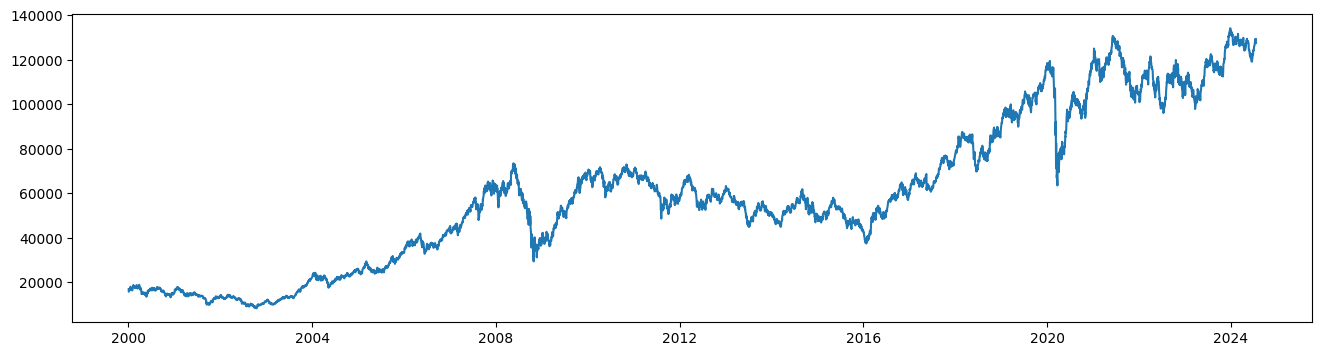

In [29]:
plt.figure(figsize=(16,4))
plt.plot(df_bs.index, df_bs.Fechamento)

## '5.1. Decompondo a Série de dados
Documentação:
1. https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
2. https://stats.stackexchange.com/questions/482089/statsmodels-seasonal-decompose-what-is-the-right-period-of-the-series-in-th

In [30]:
resultados = seasonal_decompose(df_bs['Fechamento'], period=365)

## ' 5.2. Avaliando se a série temporal é estacionária
5.2.1. Avaliação prévia via gráficos de Tendência, Sazonalidade e Resíduo

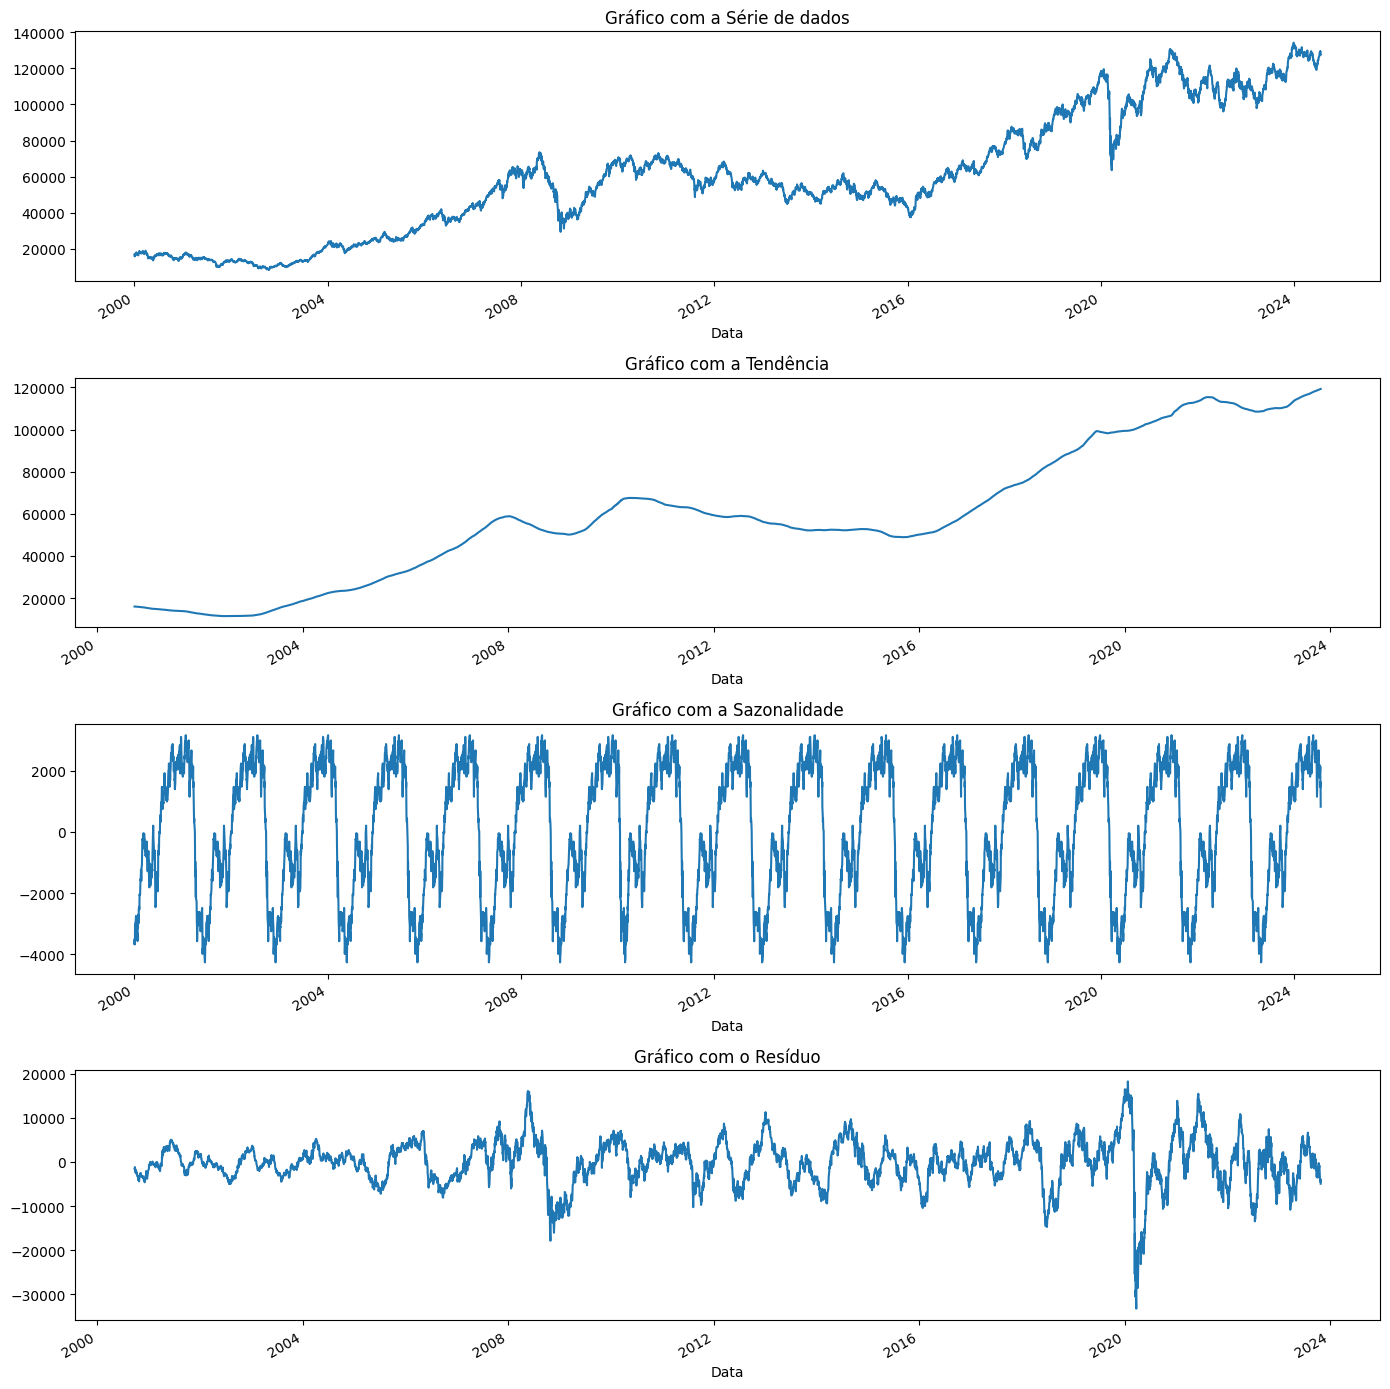

In [31]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (14,14))

#1) Gráfico com a série de dados
resultados.observed.plot(ax=ax1)
ax1.title.set_text('Gráfico com a Série de dados')

#2) Gráfico com a Tendência
resultados.trend.plot(ax=ax2)
ax2.title.set_text('Gráfico com a Tendência')

#3) Gráfico com a Sazonalidade
resultados.seasonal.plot(ax=ax3)
ax3.title.set_text('Gráfico com a Sazonalidade')

#4) Gráfico com o resíduo
resultados.resid.plot(ax=ax4)
ax4.title.set_text('Gráfico com o Resíduo')

plt.tight_layout()


#Conclusão obtida através do gráfico de tendência: como a tendência está aumentando, observa-se que não é uma Série Temporal Estacionária

5.2.2. Avaliação estatística se a Série Temporal é Estacionária ou não.
Via teste ADF - Augmented Dickey-Fuller

In [32]:
# Teste de hipótese
# Hipótese nula (H0): A Série Temporal não é Estacionária, ou seja, têm dependência temporal.
# Hipótese alternativa (H1): Rejeição à hipótese H0, ou seja, a Série Temporal  é Estacionária.

sns.set_style('darkgrid')
X = df_bs.Fechamento.values
resultado = adfuller(X)
print("Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print("Valores críticos:")



for key, Fechamento in resultado[4].items():
  print(f"\t{key}: {Fechamento}")


'''
p-valeu = 0,05 (5%), então rejeitamos H0, com um nível de confiança de 95%.
Quanto menor o P-value mais evidências contra o H0 temos.
'''
#Conclusão:#
'''Como o "Teste Estatístico" maior que os Valores Críticos e o P-Value é elevado,
 se comparado ao nosso critério de 5%.'''

Teste ADF
Teste Estatístico: -0.7179148203977447
P-Value: 0.842054465585881
Valores críticos:
	1%: -3.4314166947836924
	5%: -2.8620113829166987
	10%: -2.567020914399808


## '5.3. Transformação da Série não-estacionária em Estacionária

### '5.3.1. Com a aplicação da Aproximação/ Transformação Logarítimica
Para suavizar a série temporal e observar se a Série Temporal transforma-se em Estacionária

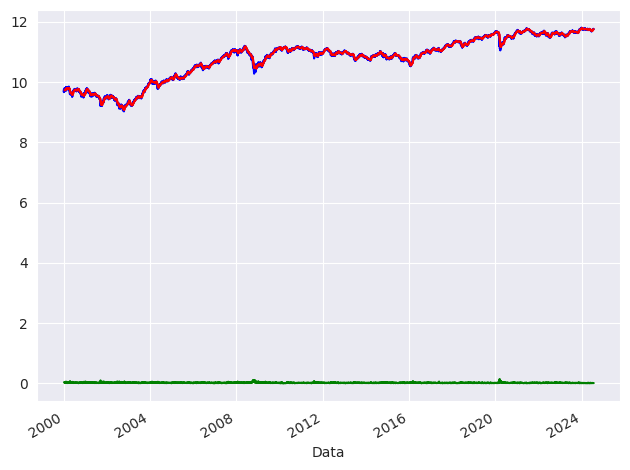

In [33]:
#Após a transformação logarítimica o resultado se mantém o mesmo.
#Apenas mudando os valores do eixo Y, de nossos valores.
df_log = np.log(df_bs)
ma_log = df_log.rolling(12).mean()
std_log = df_log.rolling(7).std()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False, color='b')
ma_log.plot(ax=ax, legend=False, color='r')
std_log.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [34]:
# Teste de hipótese
'''Hipótese nula (H0): A Série Temporal não é Estacionária, ou seja, têm dependência temporal.
Hipótese alternativa (H1): Rejeição à hipótese H0, ou seja, a Série Temporal  é Estacionária.'''


sns.set_style('darkgrid')
X = df_log.Fechamento.values
resultado = adfuller(X)
print("Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-Value: {resultado[1]}")
print("Valores críticos:")



for key, Fechamento in resultado[4].items():
  print(f"\t{key}: {Fechamento}")


#Conclusão:
'''
 p-valeu = 0,05 (5%), então rejeitamos H0, com um nível de confiança de 95%.
Quanto menor o P-value mais evidências contra o H0 temos.
 como o "Teste Estatístico" maior que os Valores Críticos e
o P-Value é elevado, se comparado ao nosso critério de 5%.'''

Teste ADF
Teste Estatístico: -1.1053327472617136
P-Value: 0.712940588421541
Valores críticos:
	1%: -3.4314179141757593
	5%: -2.8620119216812614
	10%: -2.5670212011977442


'\n p-valeu = 0,05 (5%), então rejeitamos H0, com um nível de confiança de 95%.\nQuanto menor o P-value mais evidências contra o H0 temos.\n como o "Teste Estatístico" maior que os Valores Críticos e \no P-Value é elevado, se comparado ao nosso critério de 5%.'

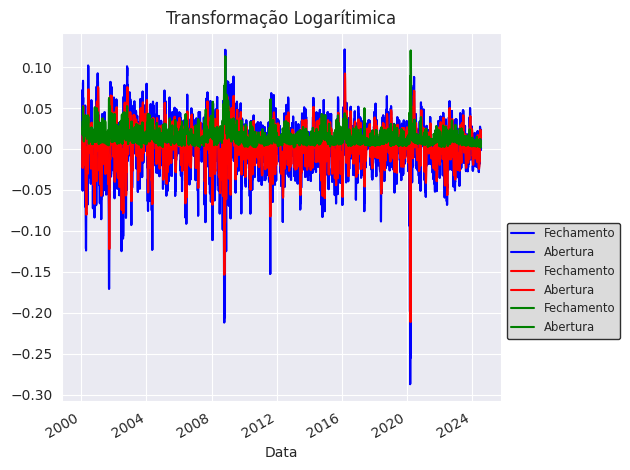

In [133]:
#Subtraindo o valor da Transformação logarítimica da média móvel e eliminando os "na",
#para não incorporar
df_s = (df_log - ma_log).dropna()

#Utilizando a janela de 7 dias na Janela temporal (Window)
ma_s = df_s.rolling(7).mean()
std = df_s.rolling(7).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False, color = 'b') #linha azul de dados reais observáveis
ma_s.plot(ax=ax, legend=False, color='r') #linha vermelha de média móvel
std.plot(ax=ax, legend=False, color='g') #linha verde de desvio padrão
plt.title("Transformação Logarítimica")

plt.legend(loc='upper left',bbox_to_anchor=(1,0.5), fontsize='small', frameon=True, facecolor='lightgrey', edgecolor='black')
plt.tight_layout()


In [36]:
#Validação do modelo ajustado por "Transformação Logarítimica" através do Teste ADF
X_s = df_s.Fechamento.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")



#Conclusão:
'''Com a aplicação do método de "Transformação Logarítimica", o "Teste
Estatístico" ficou menor que os Valores Críticos, portanto, pode-se interpretá-lo,
como Série Temporal estacionária.'''

Teste ADF
Teste Estatístico: -14.462958463832432
P-Value: 6.799496337173068e-27
Valores críticos:
	1%: -3.4314200110610207
	5%: -2.8620128481485327
	10%: -2.567021694379679


'Com a aplicação do método de "Transformação Logarítimica", o "Teste\nEstatístico" ficou menor que os Valores Críticos, portanto, pode-se interpretá-lo,\ncomo Série Temporal estacionária.'

### '5.3.2. Aplicação da 1ª Derivada
Para suavizar a média móvel, a fim de deixá-la mais próxima de Constante, a fim de transformar a série o mais próximo possível de uma Série Temporal Estacionária.
</br></br>
**Biblioteca de estudo utilizada para reforçar o conhecimento:**
* https://www.linkedin.com/pulse/um-estudo-n%C3%A3o-muito-curto-sobre-s%C3%A9ries-temporais-em-python-qvutf/
* https://medium.com/@mathslima/python-para-finan%C3%A7as-df5a7ef0248e


Teste ADF
Teste Estatístico: -21.687564447795395
P-Value: 0.0
Valores críticos:
	1%: -3.4314166947836924
	5%: -2.8620113829166987
	10%: -2.567020914399808


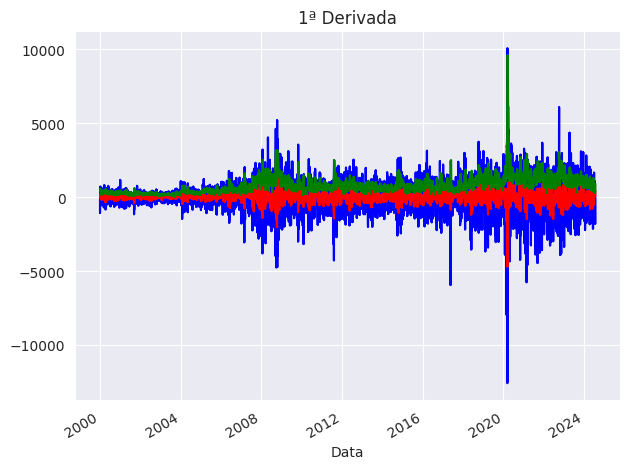

In [121]:
df_diff = df_bs.diff(1)
ma_diff = df_diff.rolling(7).mean()
std_diff = df_diff.rolling(7).std()


f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False, color='b')
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.title("1ª Derivada")
plt.tight_layout()

X_diff = df_diff.Fechamento.dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

### 5.3.3. Aplicando Técnicas de Auto-correlação (ACF e PACF)
Para entender a autocorrelação direta e indireta da série de dados.

Base diária, portanto, objetiva-se para esse caso "olhar" / "prever" 7 dias para frente.

In [38]:
#Ajustando o dataset df_diff, para conter apenas uma dimensão (coluna "Fechamento"),
## devido à demandas do modelo das Técnicas do ACF e PACF
df_diff.drop("Abertura",axis=1, inplace=True)

In [39]:
lag_acf = acf(df_diff.dropna(), nlags=7)
lag_pacf = pacf(df_diff.dropna(), nlags=7)

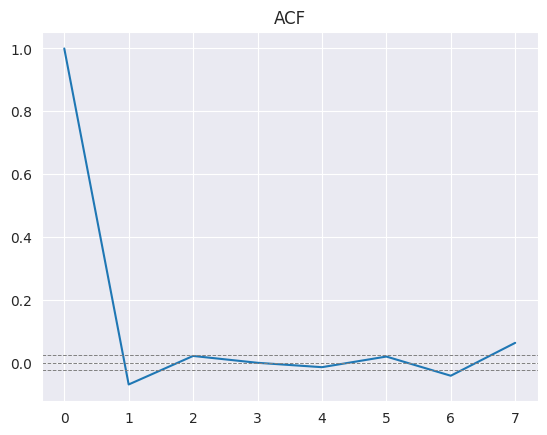

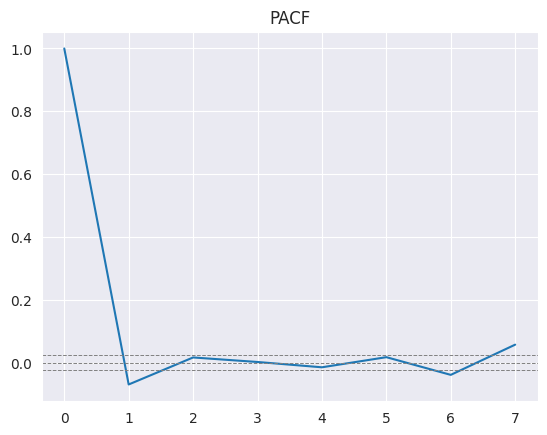

In [40]:
#ACF
plt.plot(lag_acf)

#limite inferior
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7) # o argumento -1 é devido à só ter sido diferenciada 1 vez a Série de dados.
#recorte no meio, no eixo Y = 0
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
#limite superior
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()


#PACF
plt.plot(lag_pacf)

#limite inferior
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
#recorte no meio, no eixo Y = 0
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
#limite superior
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()




##### Conclusões:
Para os termos x, y, z, a partir dos gráficos, tem-se que:
* o termo "x" é a posição do eixo "x", no (gráfico do) ACF, quando a linha cruza o limite superior pela primeira vez. Aproximadamente, seria o "1".
* o termo "Y" é a posição do eixo "x", no (gráfico do) PACF, quando a linha cruza o limite superior pela primeira vez. Aproximadamente, seria o "1".

###### Plot do gráfico do ACF e do PACF sobre a base de dados inicial que estava sem transformação logarítimica e da 1ª derivada.
Assim tem-se a banda de confiança (o hachurado azul em formato de cone em posição horizontal representa essa largura da banda de confiança)

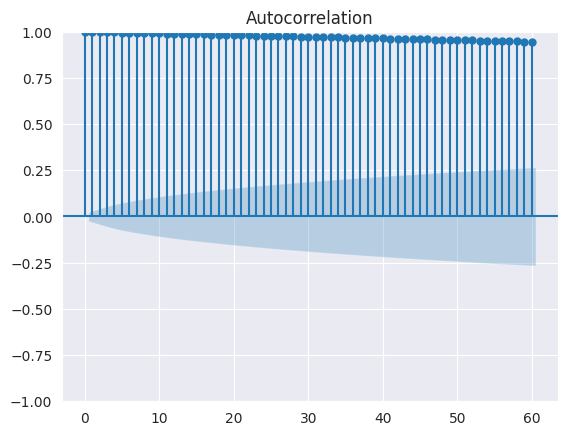

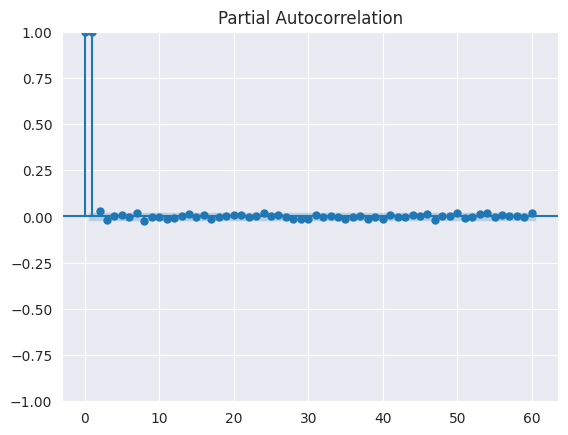

In [41]:
plot_acf(df_bs.Fechamento, lags=60)
plot_pacf(df_bs.Fechamento, lags=60)
plt.show()

**White noise ("ruído branco")** possui valores totalmente aleatórios, ou seja, não dá para prever essa série. E apresenta as seguintes características:
* É uma série que é a média é 0.
* A variância é constante durante toda a série.
* Não existe correlação entre os períodos de tempo.


Toda série temporal tem "White noise".
Toda a parte previsível da Série temporal quando é bem ajustada tem um "Overfitting" e o que resta é o "White-Noise".

#'6. Preparação dos Dados e Modelagem
## 6.1. Dividindo os Dados em Treino e Teste
Os parâmetros escolhidos foram:
* **Base de treino** de 3 meses;
* **Base de teste** com o restante do período anterior ao recorte temporal da "Base de treino".
* **h** que é a variável de horizonte de quanto tempo à frente que desejamos prever (7 dias).

In [42]:
#Formatando as colunas para o padrão dos modelos
df_bs_model = df_bs.copy(deep=True)
df_bs_model.reset_index(inplace=True)

df_bs_model = df_bs_model.rename(columns={'Data':'ds','Fechamento':'y'})
#df_bs_model.index.names = ['unique_id']
df_bs_model['unique_id'] = "Preco_Fechamento"
df_bs_model.info()
df_bs_model.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         6145 non-null   datetime64[ns]
 1   y          6145 non-null   float64       
 2   Abertura   6145 non-null   float64       
 3   unique_id  6145 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 192.2+ KB


,ds,y,Abertura,unique_id
0,2000-01-03,16930.0,17098.0,Preco_Fechamento
1,2000-01-04,15851.0,16908.0,Preco_Fechamento
2,2000-01-05,16245.0,15871.0,Preco_Fechamento


In [43]:
h = 7
train_size = df_bs_model.shape[0] - 90
train = df_bs_model[:train_size]
test = df_bs_model[train_size:]


In [44]:
print(f"O tamanho da base de treino é:{train.shape}")
print(f"O tamanho da base de teste é:{test.shape}")

print()

print(f"O valor mínimo da base de treino é: {train.index.min()}")
print(f"O valor máximo da base de treino é: {train.index.max()}")
print()
print(f"O valor mínimo da base de teste é: {test.index.min()}")
print(f"O valor máximo da base de teste é: {test.index.max()}")

O tamanho da base de treino é:(6055, 4)
O tamanho da base de teste é:(90, 4)

O valor mínimo da base de treino é: 0
O valor máximo da base de treino é: 6054

O valor mínimo da base de teste é: 6055
O valor máximo da base de teste é: 6144


In [45]:
print(train.columns)
print(test.columns)
print(train.info())
print(test.info())

Index(['ds', 'y', 'Abertura', 'unique_id'], dtype='object')
Index(['ds', 'y', 'Abertura', 'unique_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6055 entries, 0 to 6054
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         6055 non-null   datetime64[ns]
 1   y          6055 non-null   float64       
 2   Abertura   6055 non-null   float64       
 3   unique_id  6055 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 189.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 6055 to 6144
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         90 non-null     datetime64[ns]
 1   y          90 non-null     float64       
 2   Abertura   90 non-null     float64       
 3   unique_id  90 non-null     object        
dtypes: datetime64[ns](1)

#'7. Modelos

### 7.1. Método de validação da largura das bandas de erro:

* **Erro médio absoluto (MAE):** calcula em valores não percentuais a média da diferença entre o valor real com os Valores Previsto do dataframe.
* **Erro médio quadrático (MSE):** quanto maior é o valor de MSE, significa que o modelo não performou bem em relação as previsões.
* **Erro Percentual Absoluto Médio (MAPE):** métrica que mostra a porcentagem de erro do Valor Previsto/ Esperado em relação aos Valores reais, contidos no Dataframe. Suporta valores negativos;
* **Erro Percentual ponderado médio (WMAPE)**, que retorna valores absolutos (o módulo do MAPE).




</br> </br>

**Fontes bibliográficas sobre MAE, MSE e MAPE**
1. https://medium.com/data-hackers/prevendo-n%C3%BAmeros-entendendo-m%C3%A9tricas-de-regress%C3%A3o-35545e011e70
2. https://www2.ufjf.br/cursoestatistica/wp-content/uploads/sites/305/2015/05/Compara%C3%A7%C3%A3o-de-diferentes-m%C3%A9todos-de-previs%C3%A3o-em-s%C3%A9ries-temporais-com-valores-discrepantes.pdf
3. https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_MAPE.htm#PFUSU-GUID-C33B0F01-83E9-468B-B96C-413A12882334

In [46]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    wmape = np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()
    acc = (1 - mape)
    return mae, mse, mape, wmape, acc

def print_metrics(metrics):
    mae, mse, mape, wmape, acc = metrics
    print(f"MAE: {mae:.2%}")
    print(f"MSE: {mse:.2%}")
    print(f"MAPE: {mape:.2%}")
    print(f"WMAPE: {wmape:.2%}")
    print(f'Accuracy: {acc:.2%}')


def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

def mape(y_true, y_pred):
  return (y_true-y_pred).sum() / y_true.sum()

## 7.2. Criação dos Modelos

### 7.2.1. Modelo StatusForecast - baseline, sazonalidade e média móvel:
Permite trabalhar com modelo de:
* Baseline (Naive); e/ou
* Com Sazonalidade; e/ou
* Com Média móvel.

#####  O Naive retorna uma reta, por nos basearmos apenas no último dia.

#### 7.2.1.1. Modelo StatusForescast - baseline
Uso do baseline Naive, em que utilizaremos a última data com cotação para prever o restante.
Instânciando a classe do StatsForecast
* https://medium.com/@anaraquel.fiap/predicting-stock-values-with-machine-learning-and-deep-learning-algorithms-5eb028892888
* https://forecastegy.com/posts/naive-time-series-forecasting-in-python/
* https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html



Naive Metrics:
MAE: 58385.71%
MSE: 55217871.43%
MAPE: 0.46%
WMAPE: 0.46%
Accuracy: 99.54%


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


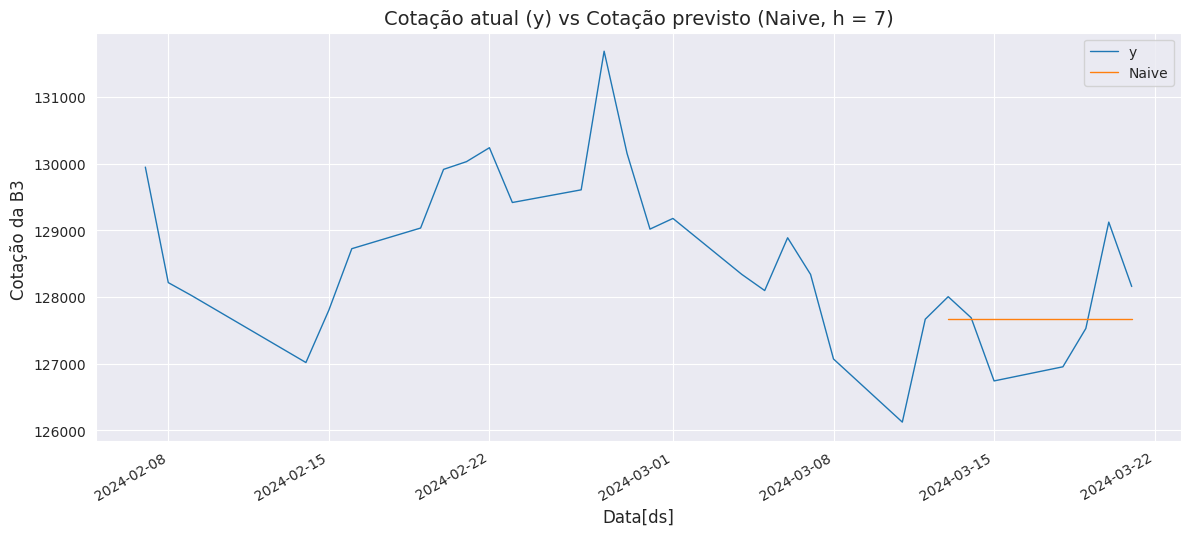

In [47]:
#freq = "B" - por ter uma base de dados com dias úteis
model_Naive = StatsForecast(models=[Naive()], freq='B', n_jobs=-1)
model_Naive.fit(train)

#Criação do Dataframe que armazenará a previsão
# Setando o grau de acuracidade e o intervalo temporal a ser previsto pelo modelo
prev_naive = model_Naive.predict(h=h, level=[90])

#Unindo os Datasets de Teste e Treino
prev_naive = prev_naive.merge(test, on=['ds', 'unique_id'], how='left')

#Retirando os valores Nulos
prev_naive = prev_naive[prev_naive['y'].notna()]
prev_naive['Naive'].isnull().sum() #Validando a retirada dos valores Nulos

#Validação do Modelo
metrics_Naive = calculate_metrics(prev_naive["y"], prev_naive['Naive'])
print("Naive Metrics:")
print_metrics(metrics_Naive)


#Grafico
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
plot_df = pd.concat([train, prev_naive]).set_index('ds').tail(30)
plot_df[['y', 'Naive']].plot(ax=ax, linewidth=1)
ax.set_title('Cotação atual (y) vs Cotação previsto (Naive, h = 7)', fontsize=14)
ax.set_ylabel('Cotação da B3 ', fontsize=12)
ax.set_xlabel('Data[ds]', fontsize=12)
ax.legend(prop={'size': 10})
ax.grid(True)


#### 7.2.1.2. Modelo StatsForecast - Sazonalidade (+baseline)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Seasonal Naive Metrics:
MAE: 117528.57%
MSE: 232434785.71%
MAPE: 0.92%
WMAPE: 0.92%
Accuracy: 99.08%


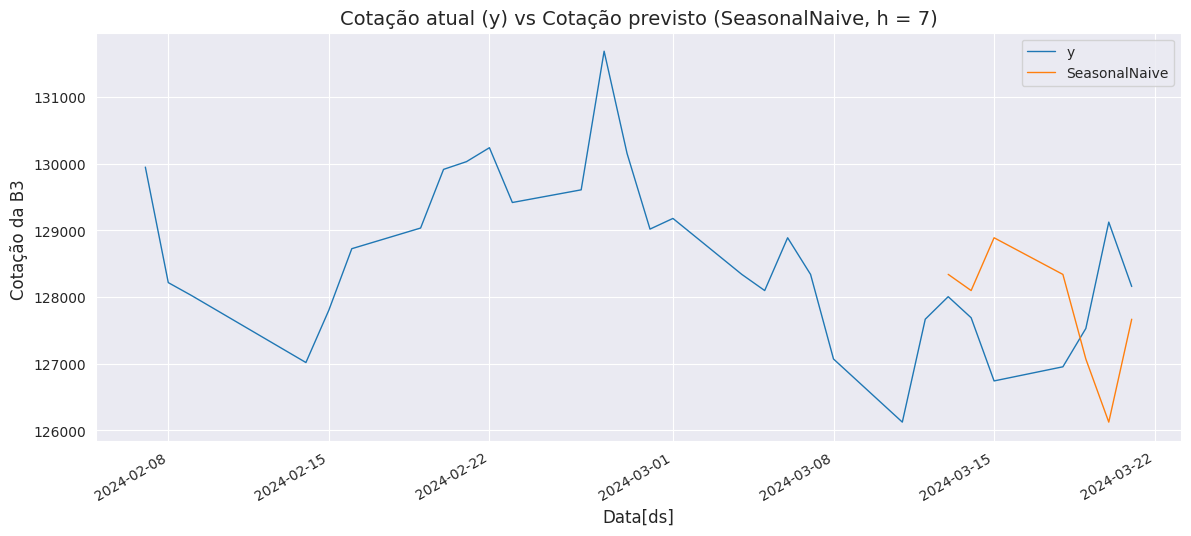

In [48]:
model_Seasonal_Naive = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='B', n_jobs=-1)
model_Seasonal_Naive.fit(train)

prev_Seasonal_Naive = model_Seasonal_Naive.predict(h=h, level=[90])
prev_Seasonal_Naive = prev_Seasonal_Naive.reset_index().merge(test, on=['ds', 'unique_id'], how='left')

#Retirando os valores Nulos
prev_Seasonal_Naive = prev_Seasonal_Naive[prev_Seasonal_Naive['y'].notna()]
#Validando
prev_Seasonal_Naive['SeasonalNaive'].isnull().sum() #Validando a retirada dos valores Nulos

#Validação do Modelo
metrics_Seasonal_Naive = calculate_metrics(prev_Seasonal_Naive["y"], prev_Seasonal_Naive['SeasonalNaive'])
print("Seasonal Naive Metrics:")
print_metrics(metrics_Seasonal_Naive)


#Grafico
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
plot_df = pd.concat([train, prev_Seasonal_Naive]).set_index('ds').tail(30)
plot_df[['y', 'SeasonalNaive']].plot(ax=ax, linewidth=1)
ax.set_title('Cotação atual (y) vs Cotação previsto (SeasonalNaive, h = 7)', fontsize=14)
ax.set_ylabel('Cotação da B3 ', fontsize=12)
ax.set_xlabel('Data[ds]', fontsize=12)
ax.legend(prop={'size': 10})
ax.grid(True)

#### 7.2.1.3. Modelo StatsForest - com média móvel (+Sazonalidade +BaseLine)
Sazonalidade = 1 semana (7 dias)
Window_size (média móvel) = de 2 semanas (2)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Seasonal Window Average Metrics:
MAE: 146385.71%
MSE: 293452485.71%
MAPE: 1.15%
WMAPE: 1.15%
Accuracy: 98.85%


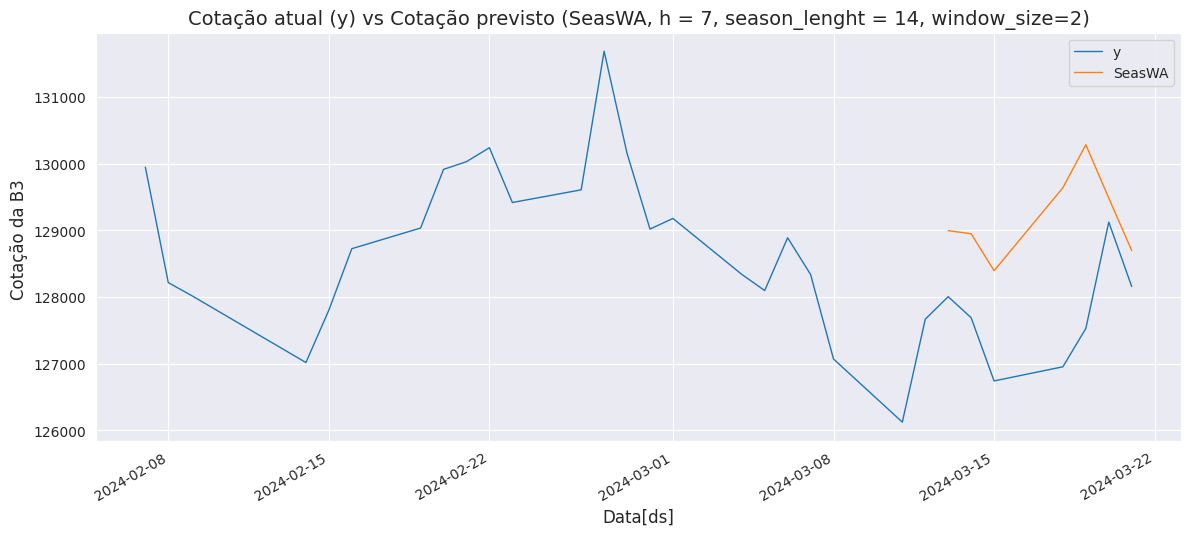

In [49]:
model_Seasonal_Wdw_Avg = StatsForecast(models=[SeasonalWindowAverage(season_length=14, window_size=2)], freq='B', n_jobs=-1)
model_Seasonal_Wdw_Avg.fit(train)

prev_Seasonal_Wdw_Avg = model_Seasonal_Wdw_Avg.predict(h=h)
prev_Seasonal_Wdw_Avg = prev_Seasonal_Wdw_Avg.reset_index().merge(test, on=['ds', 'unique_id'], how='left')


#Retirando os valores Nulos
prev_Seasonal_Wdw_Avg = prev_Seasonal_Wdw_Avg[prev_Seasonal_Wdw_Avg['y'].notna()]
prev_Seasonal_Wdw_Avg['SeasWA'].isnull().sum() #Validando a retirada dos valores Nulos

#Validação do Modelo
metrics_Seasonal_Wdw_Avg = calculate_metrics(prev_Seasonal_Wdw_Avg["y"], prev_Seasonal_Wdw_Avg['SeasWA'])
print("Seasonal Window Average Metrics:")
print_metrics(metrics_Seasonal_Wdw_Avg)


#Grafico
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
plot_df = pd.concat([train, prev_Seasonal_Wdw_Avg]).set_index('ds').tail(30)
plot_df[['y', 'SeasWA']].plot(ax=ax, linewidth=1)
ax.set_title('Cotação atual (y) vs Cotação previsto (SeasWA, h = 7, season_lenght = 14, window_size=2)', fontsize=14)
ax.set_ylabel('Cotação da B3 ', fontsize=12)
ax.set_xlabel('Data[ds]', fontsize=12)
ax.legend(prop={'size': 10})
ax.grid(True)

#### 7.2.1.4. Modelo AutoARIMA
O modelo arima apresenta as seguintes características:
* Modelo Autorregressivo;
* Modelo Integrado;
* Média Móvel.

In [50]:
train_ARIMA = train.drop(["Abertura"], axis=1)
train_ARIMA.head(2)

,ds,y,unique_id
0,2000-01-03,16930.0,Preco_Fechamento
1,2000-01-04,15851.0,Preco_Fechamento


In [51]:
#ARIMA - AR: olha para as vendas do passado e acha uma correlação futura
# I - quantidade que a série foi diferenciada/ MA: Média Móvel
model_ARIMA = StatsForecast(models=[AutoARIMA(season_length=7)], freq='B', n_jobs=-1)
model_ARIMA.fit(train_ARIMA)

prev_ARIMA = model_ARIMA.predict(h=h, level=[90])
prev_ARIMA

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
Preco_Fechamento,2024-03-13,127508.796875,125854.242188,129163.351562
Preco_Fechamento,2024-03-14,127500.992188,125240.976562,129761.007812
Preco_Fechamento,2024-03-15,127550.085938,124811.015625,130289.148438
Preco_Fechamento,2024-03-18,127515.671875,124369.945312,130661.398438
Preco_Fechamento,2024-03-19,127436.187500,123930.648438,130941.726562
Preco_Fechamento,2024-03-20,127376.867188,123545.164062,131208.578125
Preco_Fechamento,2024-03-21,127473.578125,123341.367188,131605.796875


ARIMA Metrics:
MAE: 65461.94%
MSE: 68368553.08%
MAPE: 0.51%
WMAPE: 0.51%
Accuracy: 99.49%


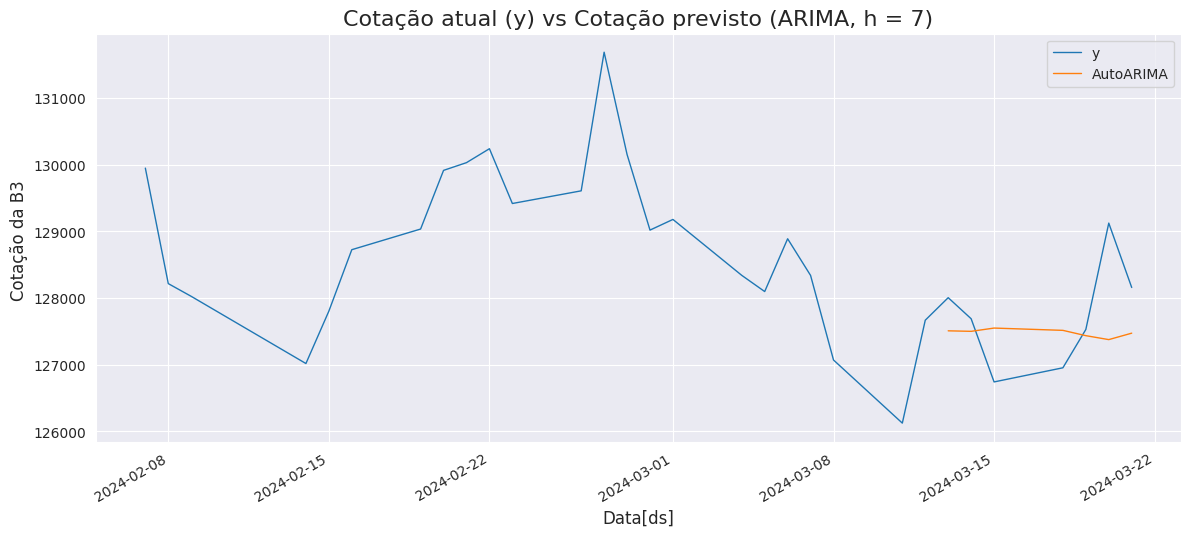

In [52]:
#Unindo os Datasets de Teste e Treino
prev_ARIMA = prev_ARIMA.merge(test, on=['ds', 'unique_id'], how='left')

#Retirando os valores Nulos
prev_ARIMA = prev_ARIMA[prev_ARIMA['y'].notna()]
prev_ARIMA['AutoARIMA'].isnull().sum() #Validando a retirada dos valores Nulos

#Calculando Metricas
metrics_ARIMA = calculate_metrics(prev_ARIMA["y"], prev_ARIMA['AutoARIMA'])
print("ARIMA Metrics:")
print_metrics(metrics_ARIMA)


#Grafico
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
plot_df = pd.concat([train_ARIMA, prev_ARIMA]).set_index('ds').tail(30)
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=1)
ax.set_title('Cotação atual (y) vs Cotação previsto (ARIMA, h = 7)', fontsize=16)
ax.set_ylabel('Cotação da B3 ', fontsize=12)
ax.set_xlabel('Data[ds]', fontsize=12)
ax.legend(prop={'size': 10})
ax.grid(True)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 0.51%


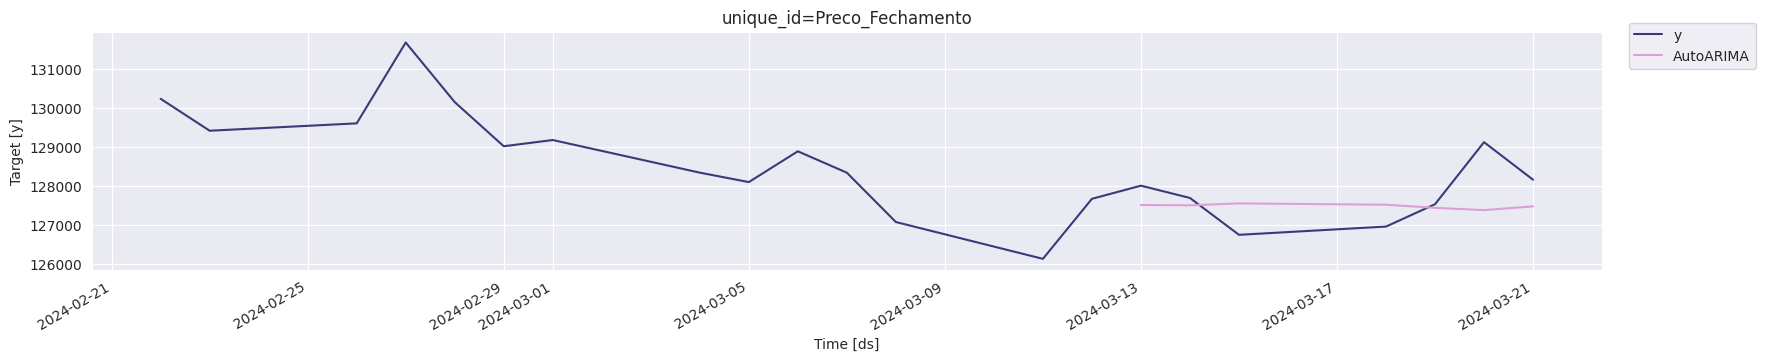

In [53]:
forecast_dfa = model_ARIMA.predict(h=h)
forecast_dfa = forecast_dfa.reset_index().merge(test, on=['ds', 'unique_id'], how='left')

wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")


model_ARIMA.plot(train, forecast_dfa[['ds','y','unique_id','AutoARIMA']],engine ='matplotlib', max_insample_length=14)

###7.2.2. Modelo XGBoost

#### 7.2.2.1. Preparação dos dados para o modelo do XGBoost

In [54]:
def create_features(df_bs_model):
    df_bs_model["year"] = df_bs_model["ds"].dt.year
    df_bs_model["month"] = df_bs_model["ds"].dt.month
    df_bs_model["day"] = df_bs_model["ds"].dt.day
    df_bs_model["dayofweek"] = df_bs_model["ds"].dt.dayofweek
    return df_bs_model


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "Abertura"]
TARGET = "y"

<ipython-input-54-87903c299a30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_model["year"] = df_bs_model["ds"].dt.year
<ipython-input-54-87903c299a30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bs_model["month"] = df_bs_model["ds"].dt.month
<ipython-input-54-87903c299a30>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

#### 7.2.2.2. Criação do modelo XGBoost

In [55]:
train.head(2)

,ds,y,Abertura,unique_id,year,month,day,dayofweek
0,2000-01-03,16930.0,17098.0,Preco_Fechamento,2000,1,3,0
1,2000-01-04,15851.0,16908.0,Preco_Fechamento,2000,1,4,1


In [56]:
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### 7.2.2.3. Avaliação do Modelo XGBoost

In [57]:
prev_XGB = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, prev_XGB)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 98817.88%
MSE: 151881609.59%
MAPE: 0.79%
WMAPE: 0.79%
Accuracy: 99.21%


In [58]:
#Criando um data frame com o mesmo indice compativel ao dataset
df_prev_XGB = pd.DataFrame(prev_XGB, index=np.arange(6055, 6145))

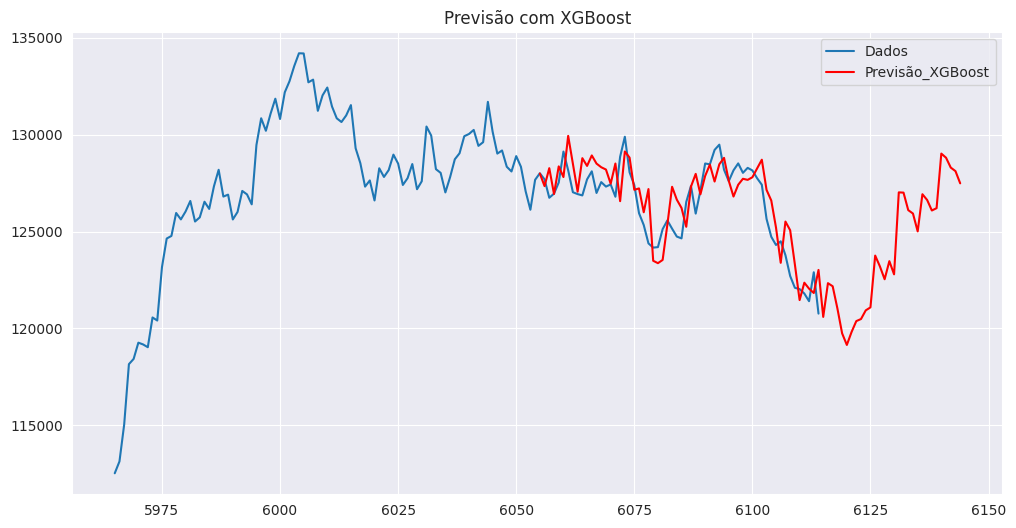

In [122]:
# Plotar previsões
plt.figure(figsize=(12, 6))
plt.plot(df_bs_model['y'][-180:-30], label='Dados')
plt.plot(df_prev_XGB, label='Previsão_XGBoost', color='red')
plt.legend()
plt.title('Previsão com XGBoost')
plt.show()

### 7.2.3. Modelo Prophet

#### 7.2.3.1. Preparação dos dados para o Modelo do Prophet

In [60]:
train_prophet = train.rename(columns={"Data": "ds", "Fechamento": "y"})
test_prophet = test.rename(columns={"Data": "ds", "Fechamento": "y"})

#### 7.2.3.2. Criação do modelo Prophet

In [74]:
model = Prophet(daily_seasonality=True)
model.add_regressor("Abertura")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["Abertura"] = pd.concat([train["Abertura"], test["Abertura"]], ignore_index=True)
forecast = model.predict(future)

preds = forecast[["ds", "yhat"]].tail(len(test))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]


DEBUG:cmdstanpy:input tempfile: /tmp/tmptjpujsr5/nt2_ulap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptjpujsr5/ayii8jrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32364', 'data', 'file=/tmp/tmptjpujsr5/nt2_ulap.json', 'init=/tmp/tmptjpujsr5/ayii8jrf.json', 'output', 'file=/tmp/tmptjpujsr5/prophet_modelpuzwihul/prophet_model-20240730231101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### 7.2.3.2. Avaliação do Modelo Prophet

In [75]:
metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

Prophet Metrics:
MAE: 355938.11%
MSE: 1866047044.71%
MAPE: 2.85%
WMAPE: 1.49%
Accuracy: 97.15%


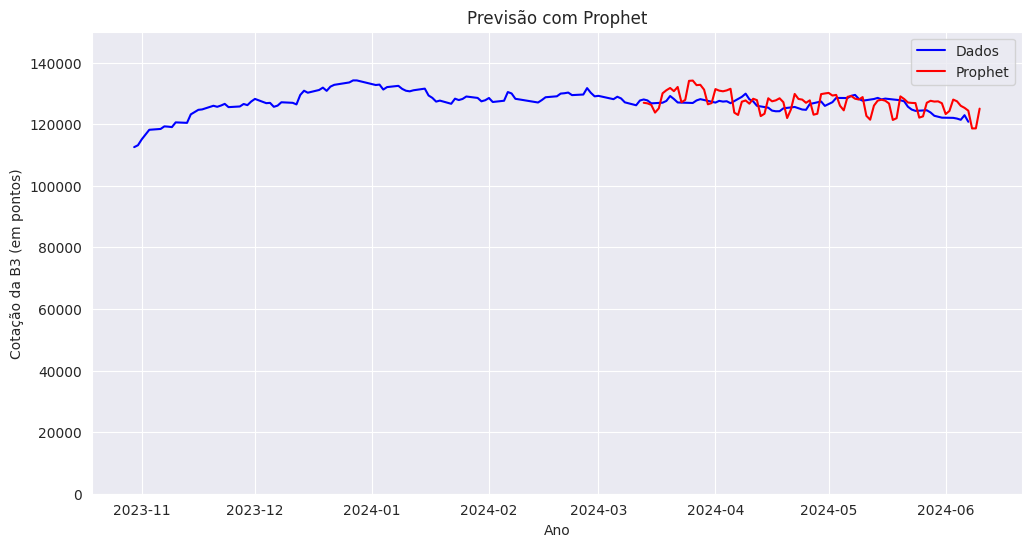

In [119]:
# Plotar previsões
plt.figure(figsize=(12, 6))
plt.plot(df_bs['Fechamento'][-180:-30], label='Dados', color='blue')
plt.plot(preds, label='Prophet', color='red')



plt.xlabel("Ano")
plt.ylabel("Cotação da B3 (em pontos)")

plt.ylim(0,150_000)
plt.legend()
plt.title('Previsão com Prophet')
plt.show()

### 7.2.4. Modelo SARIMAX

#### 7.2.4.1. Criação do modelo SARIMAX

Como discutido no indice 5.3 os parametros para o ARIMA(p, d, q), seriam (1, 1, 1)

In [76]:
#Criando df para o modelo
exog_train = train[["Abertura"]]
exog_test = test[["Abertura"]]

In [77]:
df_sazional = pd.DataFrame(resultados.seasonal)
df_sazional.head()

,seasonal
Data,
2000-01-03,-3652.035459
2000-01-04,-3497.000357
2000-01-05,-3672.175357
2000-01-06,-3522.528096
2000-01-07,-3004.101384


In [78]:
#Teste ADF para verificar estacionaridade
X = df_sazional.dropna().values
result_diff = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -6.805736054563527
P-Value: 2.1792174728827016e-09
Valores críticos:
	1%: -3.4314207118538866
	5%: -2.8620131577798515
	10%: -2.5670218592042775


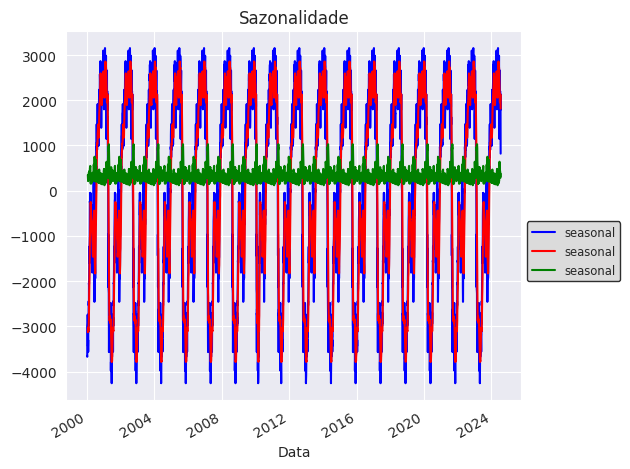

In [143]:
#Plot do Decompose - Sazional ---> p-value < 0,05, logo estacionario ----> D = 0
ma_sazional = df_sazional.rolling(12).mean()
std_sazional = df_sazional.rolling(12).std()

f, ax = plt.subplots()
df_sazional.plot(ax=ax, legend =False,color='b') #linha azul de dados reais observáveis
ma_sazional.plot(ax=ax, legend =False,color='r') #linha vermelha de média móvel
std_sazional.plot(ax=ax, legend =False,color='g')#linha verde de desvio padrão


plt.legend(loc='upper left',bbox_to_anchor=(1,0.5), fontsize='small', frameon=True, facecolor='lightgrey', edgecolor='black')

plt.title("Sazonalidade")
plt.tight_layout()


In [80]:
lag_acf = acf(df_sazional.dropna(), nlags=100)
lag_pacf = pacf(df_sazional.dropna(), nlags=7)

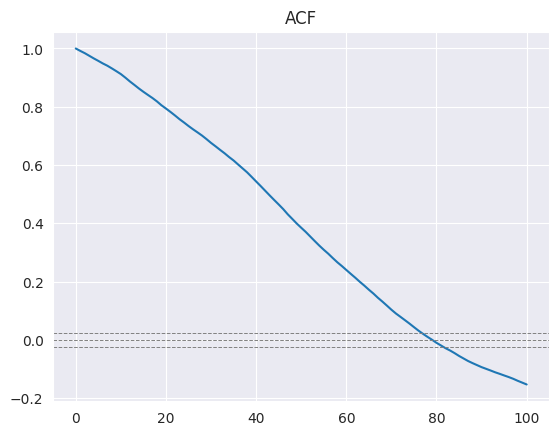

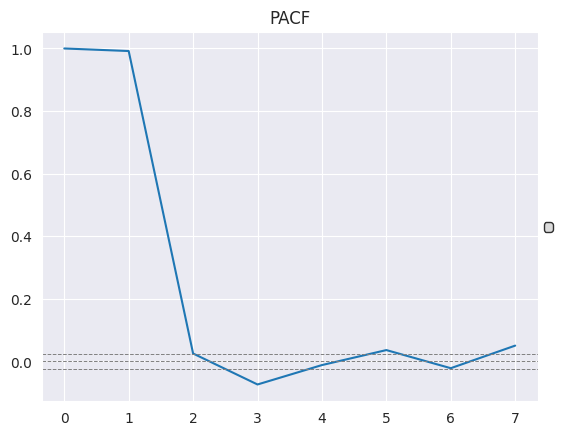

In [134]:
#ACF
plt.plot(lag_acf)

#limite inferior
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -0))), linestyle='--', color='gray',linewidth=0.7) # o argumento -0 é devido à só ter sido diferenciada 1 vez a Série de dados.
#recorte no meio, no eixo Y = 0
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
#limite superior
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -0))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()


#PACF
plt.plot(lag_pacf)

#limite inferior
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -0))), linestyle='--', color='gray',linewidth=0.7)
#recorte no meio, no eixo Y = 0
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
#limite superior
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -0))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()

#### 7.2.4.2. Avaliação do Modelo SARIMAX

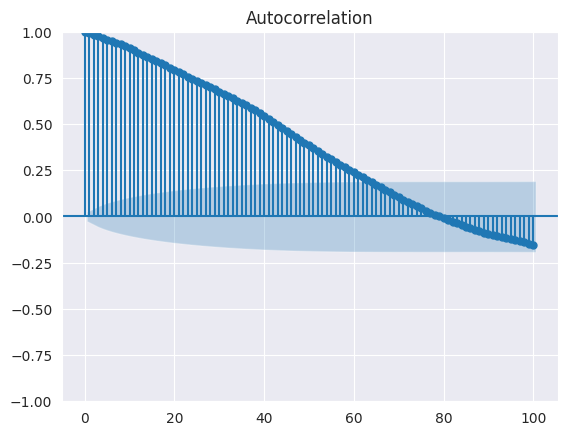

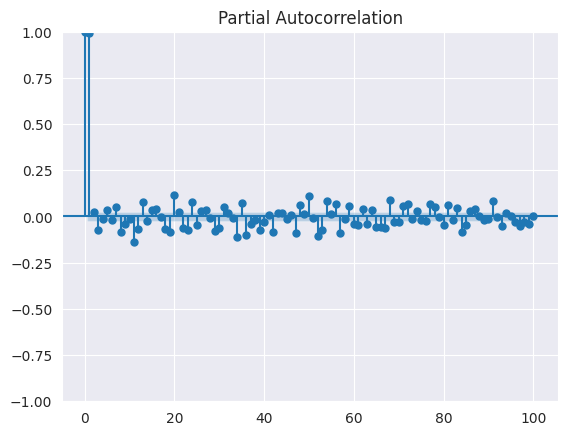

In [82]:
#Plot do gráfico do ACF e PACF para escolha os parametros para o SARIMA
plot_acf(df_sazional, lags=100)
plot_pacf(df_sazional, lags=100)
plt.show()

In [83]:
#Parametros(P, D, Q) => (75, 0, 2)
model = sm.tsa.statespace.SARIMAX(
    train["y"], exog=exog_train, order=(1, 1, 1), seasonal_order=(5, 0, 2, 12)# foi escolhido 5 pelo custo computacional
)
results = model.fit()

prev_SARIMAX = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [84]:
prev_SARIMAX.head()

,predicted_mean
6055,127495.284011
6056,127634.940286
6057,127519.325343
6058,127358.807183
6059,127386.150757


In [85]:
metrics_sarimax = calculate_metrics(test["y"], prev_SARIMAX)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 204595.43%
MSE: 795050139.11%
MAPE: 1.66%
WMAPE: 1.63%
Accuracy: 98.34%


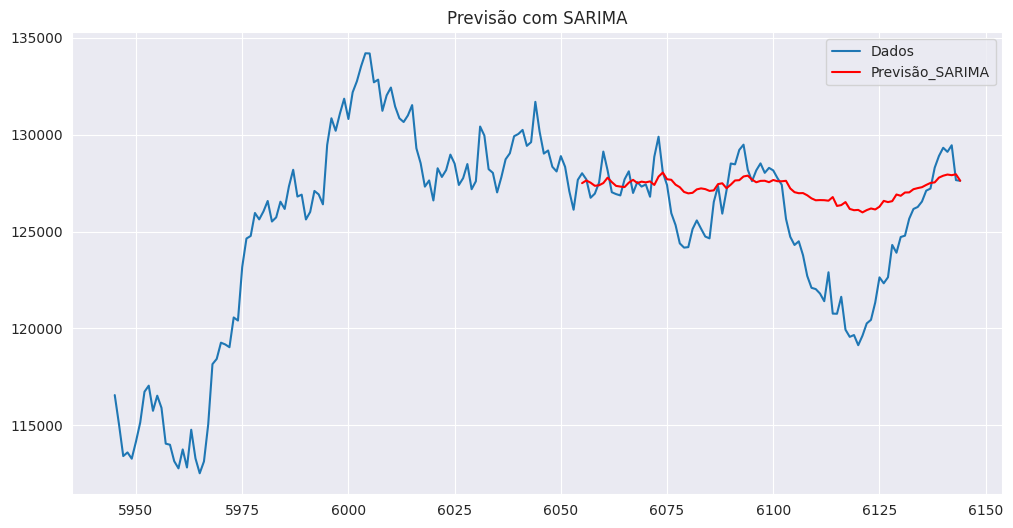

In [87]:
# Plotar previsões
plt.figure(figsize=(12, 6))
plt.plot(df_bs_model['y'][-200:], label='Dados')
plt.plot(prev_SARIMAX, label='Previsão_SARIMA', color='red')
plt.legend()
plt.title('Previsão com SARIMA')
plt.show()

# '8. Comparação dos Modelos

In [146]:
df_Comp_Modelos = pd.DataFrame(
                  [metrics_Naive, metrics_Seasonal_Naive, metrics_Seasonal_Wdw_Avg, metrics_ARIMA, metrics_xgb, metrics_pr, metrics_sarimax],
                  columns=["MAE", "MSE", "MAPE","WMAPE", "Accuracy"],
                  index=["Naive", "Seasonal Naive", "Seasonal Window Average", "AutoARIMA","XGBoost", "Prophet", "SARIMAX"],
)

In [147]:
df_Comp_Modelos.style.format({
                              'MAE': '{:,.3f}'.format
                              ,'MSE': '{:,.3f}'.format
                              ,'MAPE': '{:,.3f}'.format
                              ,'WMAPE': '{:,.3f}'.format
                              ,'Accuracy': '{:,.3f}'.format
                               })

,MAE,MSE,MAPE,WMAPE,Accuracy
Naive,583.857,"552,178.714",0.005,0.005,0.995
Seasonal Naive,"1,175.286","2,324,347.857",0.009,0.009,0.991
Seasonal Window Average,"1,463.857","2,934,524.857",0.011,0.011,0.989
AutoARIMA,654.619,"683,685.531",0.005,0.005,0.995
XGBoost,988.179,"1,518,816.096",0.008,0.008,0.992
Prophet,"3,559.381","18,660,470.447",0.028,0.015,0.972
SARIMAX,"2,045.954","7,950,501.391",0.017,0.016,0.983


(0.95, 1.0)

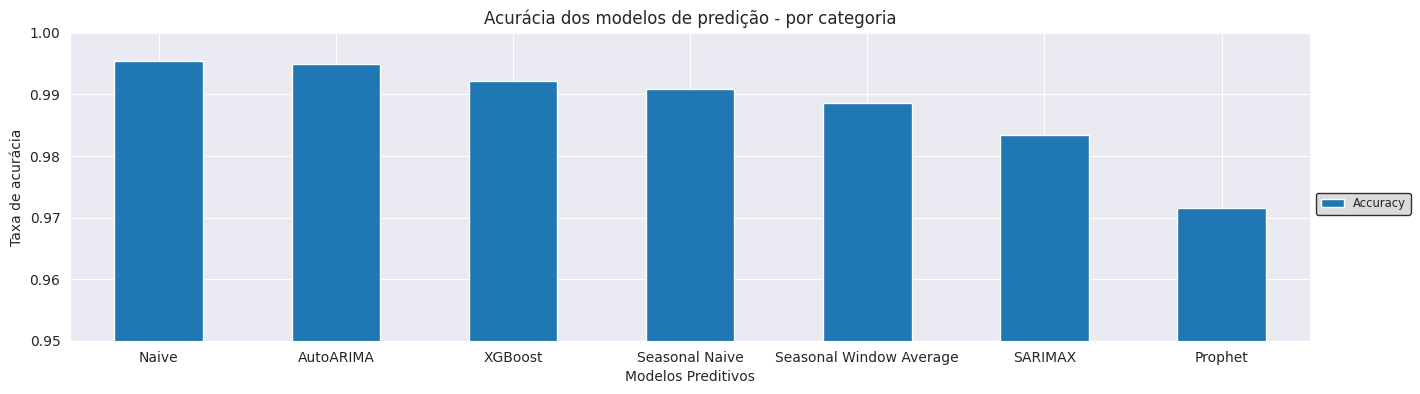

In [149]:
#ACCURACY
df_Comp_Modelos_ord = df_Comp_Modelos.sort_values(by='Accuracy', ascending=False)
df_Comp_Modelos_ord['Accuracy'].plot(kind="bar",figsize=(16,4))

#Mudança de título do gráfico
plt.title("Acurácia dos modelos de predição - por categoria")
#4) Mudança de título dos eixos
plt.xlabel("Modelos Preditivos")
plt.ylabel("Taxa de acurácia")
# Rotação Tick parâmetros dos eixos
plt.tick_params(labelrotation=0)
#Legenda de dados
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5), fontsize='small', frameon=True, facecolor='lightgrey', edgecolor='black')

#Plot do gráfico
plt.ylim(0.95,1)



(0.0, 4000.0)

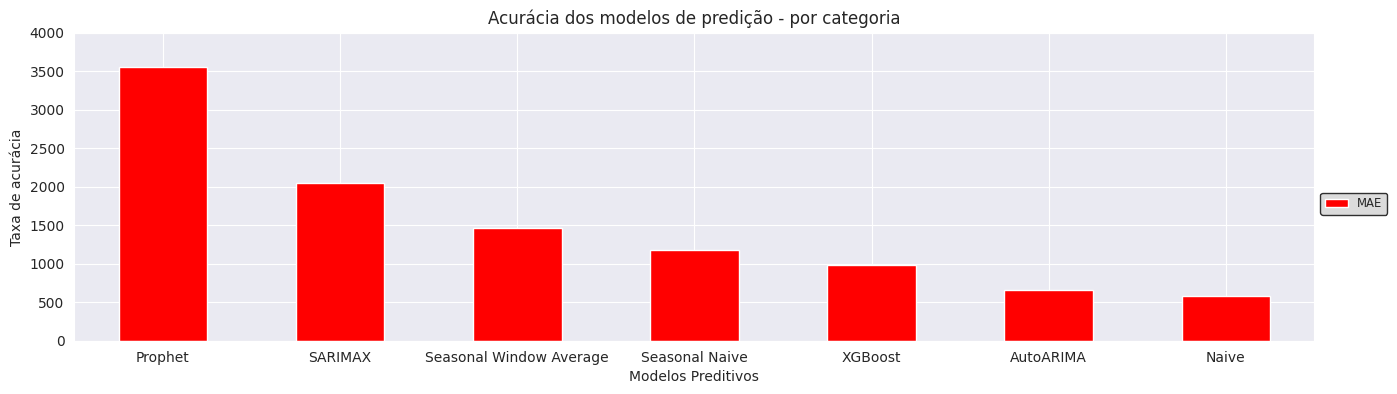

In [150]:
#MAE
df_Comp_Modelos_ord = df_Comp_Modelos.sort_values(by='MAE', ascending=False)
df_Comp_Modelos_ord['MAE'].plot(kind="bar",figsize=(16,4), color="red")

#Mudança de título do gráfico
plt.title("Acurácia dos modelos de predição - por categoria")
#4) Mudança de título dos eixos
plt.xlabel("Modelos Preditivos")
plt.ylabel("Taxa de acurácia")
# Rotação Tick parâmetros dos eixos
plt.tick_params(labelrotation=0)
#Legenda de dados
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5), fontsize='small', frameon=True, facecolor='lightgrey', edgecolor='black')

#Plot do gráfico
plt.ylim(0,4000)

(0.0, 0.03)

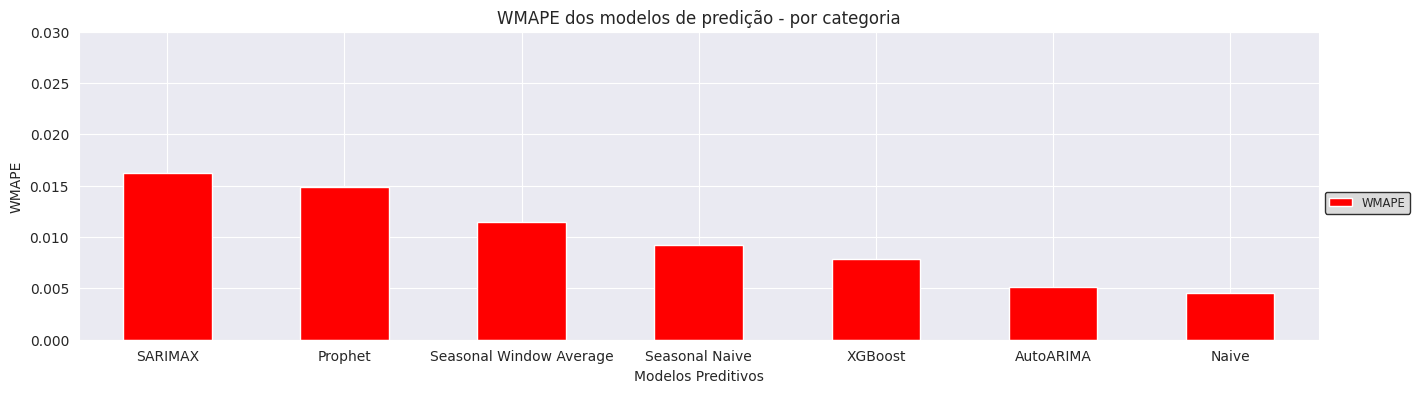

In [152]:
#WMAPE
df_Comp_Modelos_ord = df_Comp_Modelos.sort_values(by='WMAPE', ascending=False)
df_Comp_Modelos_ord['WMAPE'].plot(kind="bar",figsize=(16,4), color="red")

#Mudança de título do gráfico
plt.title("WMAPE dos modelos de predição - por categoria")
#4) Mudança de título dos eixos
plt.xlabel("Modelos Preditivos")
plt.ylabel("WMAPE")
# Rotação Tick parâmetros dos eixos
plt.tick_params(labelrotation=0)
#Legenda de dados
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5), fontsize='small', frameon=True, facecolor='lightgrey', edgecolor='black')

#Plot do gráfico
plt.ylim(0,0.03)

(0.0, 0.03)

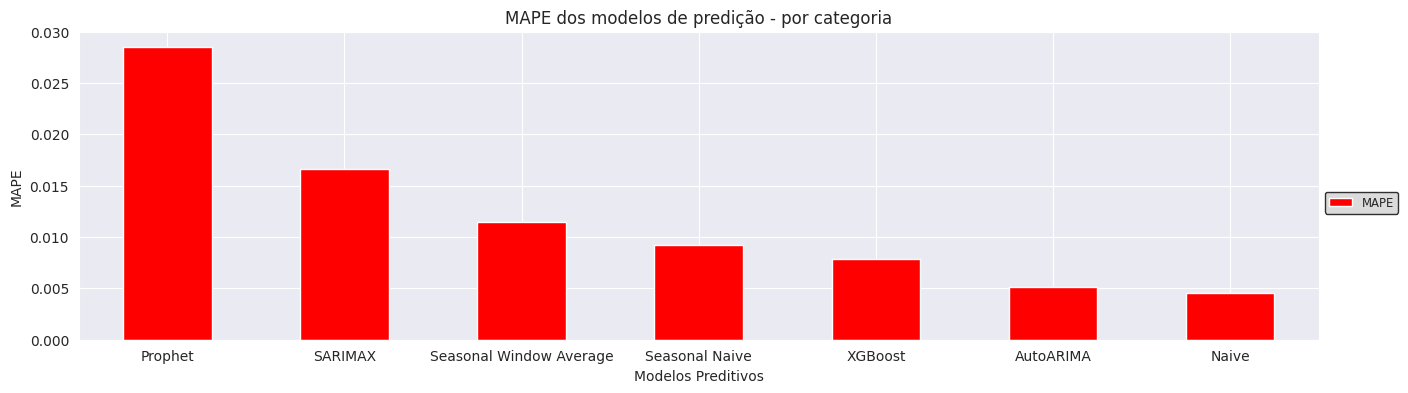

In [154]:
#MAPE
df_Comp_Modelos_ord = df_Comp_Modelos.sort_values(by='MAPE', ascending=False)
df_Comp_Modelos_ord['MAPE'].plot(kind="bar",figsize=(16,4), color="red")

#Mudança de título do gráfico
plt.title("MAPE dos modelos de predição - por categoria")
#4) Mudança de título dos eixos
plt.xlabel("Modelos Preditivos")
plt.ylabel("MAPE")
# Rotação Tick parâmetros dos eixos
plt.tick_params(labelrotation=0)
#Legenda de dados
plt.legend(loc='upper left',bbox_to_anchor=(1,0.5), fontsize='small', frameon=True, facecolor='lightgrey', edgecolor='black')

#Plot do gráfico
plt.ylim(0,0.03)

# '9. Conclusão


> Todos os modelos apresentaram resultados parecidos, seja de acuracidade, seja de seus erros, com exceção do Prophet, que apresentou níveis de acuracidade menores que dos demais e também apresentou métricas de erro também maiores que dos demais modelos.
</br>

> Com isso, o MAE e do MAPE, conforme bibliografia suporte corrobora (https://medium.com/data-hackers/prevendo-n%C3%BAmeros-entendendo-m%C3%A9tricas-de-regress%C3%A3o-35545e011e70), são técnicas que não são tão afetadas por valores discrepantes e possuem melhor interpretabilidade de seus resultados para fins de entendimento da divergência entre o previsto e o observado. E a partir dessas duas técnicas (MAE e o MAPE) observou-se 4 modelos que melhor performaram: ***XGBoost, Sarimax, AutoArima e Naive.***
</br>

> Foram utilizados dados da B3, desde 01/01/2000 até 15/07/2024, após filtrarmos dados apenas a partir do ano 2000, já que é onde há maiores detalhamento dos anos com os dados de cotação da B3, de maneira mais robusta.
</br>

> Em resumo, a nossa melhor taxa de acerto é menor média de erro quadrado, foi na utilização do modelo **XGBoost** entendendo melhor o modelo. A seguir, seguem os pontos do porquê de esse modelo se mostrar aderem ao propósito das predições almejadas para a tomada de decisão de escolha final:</br>
- O modelo apresenta uma facilidade para lidar com dados faltantes na base de dados, não enviesando o modelo final.
- ⁠O modelo trabalha com um conceito de árvore de decisão, o que permite que esses outliers que podem faltar não influenciem no lado tomado pelo modelo.

>**Conclusão:**
</br>O modelo (XGBoost) se mostrou com os melhores indicadores, pelo fato de trabalhar melhor com séries temporais, e consequentemente a base de dados fornecida e trabalhada ser uma série temporal. E com isso, a base de teste teve seus dados previstos mais aderentes com a base de treino, quando comparamos no gráfico do modelo do XGBoost (vide navegação desse script no índice "***7.2.2.3. Avaliação do Modelo XGBoost***".
</br></br>

Vide Imagem abaixo do Modelo XGBoost
</br></br>
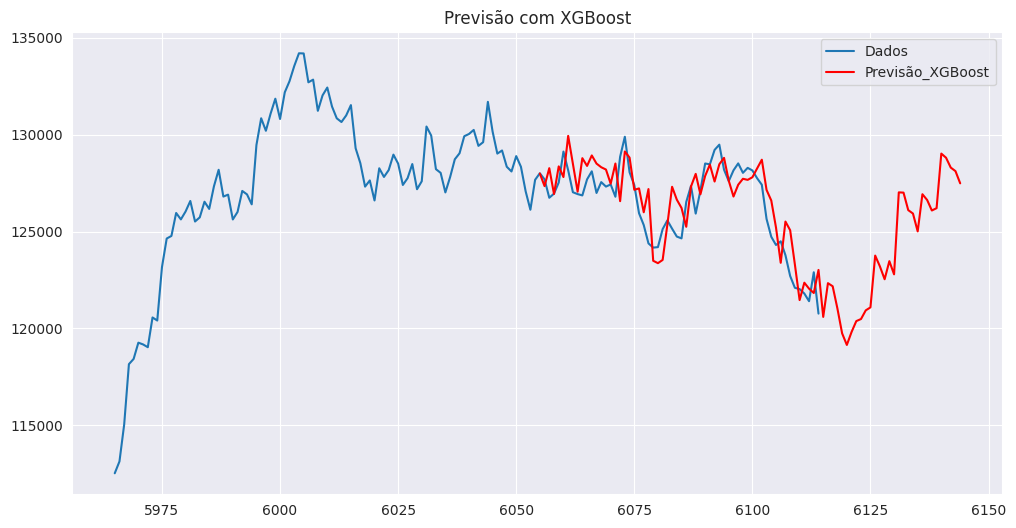
